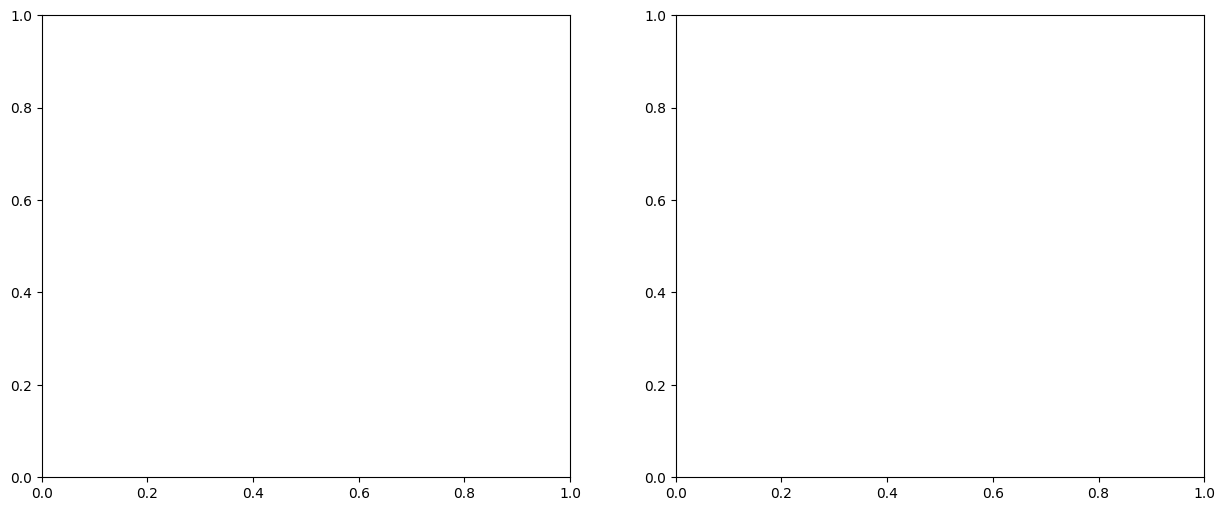

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tkinter as tk
from tkinter import ttk, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.dates as mdates

#Data load I understood that in order_items we have the id's of groups of products and in them their prices, and there can be several id's assigned to one group, so first we needed a
#products.csv file from which all id's belonging to a specific group and the name of this group were extracted to then extract from the order_items file the prices of orders where 
# the id of a specific group and the date of the order to see how the price varied over time 
# the prodcuts_category_name_translation file was used to convert product group names from Portuguese to English
products = pd.read_csv('products.csv')
order_items = pd.read_csv('order_items.csv')
translations = pd.read_csv('product_category_name_translation.csv')

# standardisation of the date format
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

# Function which removes negative prices and the value 0
def clean_data(df):
    df = df[df['price'] > 0]  
    return df

# Throwing out the outliners so as not to disturb the graph and I noticed that in one case one group of products had an average value of about 65 and in one case an order 
# was worth 6000
def remove_outliers(df, column_name, threshold=3):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df_filtered

# Function to create and train a Random Forest model for price. I choose random forest bcs Among all the available classification methods, random forests provide the highest accuracy. 
# The random forest technique can also handle big data with numerous variables running into thousands 
# and At university we mainly worked with random forst and XGBOOST, but its only advantage is that it detects empty values that have been removed by the function.
def create_rf_model(train_data, category_name, ax1, ax2):
    train_data.set_index('shipping_limit_date', inplace=True)
    #Sorting orders from oldest
    train_data = train_data.sort_index(ascending=True) 
    # clearing of zeros
    train_data = clean_data(train_data)
    #protection against making predictions when a product group has been ordered only once in the history
    if len(train_data) < 2:
        print(f"Not enough recent data for selected products. Skipping.")
        return
    # replacing empty values with the previous value to eliminate empty spaces
    train_data = train_data.resample('D').mean().fillna(method='ffill')  
    
    # invoking fucknji deleting outliners on a collection
   
    train_data = remove_outliers(train_data, 'price')
    
    # data preparation for the model and training
    train_data['day_of_week'] = train_data.index.dayofweek
    train_data['month'] = train_data.index.month
    
    X = train_data[['day_of_week', 'month']].values
    y = train_data['price'].values
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # price prediction 14 days after last order
    forecast_period = 14  
    forecast_dates = pd.date_range(start=train_data.index.max() + pd.Timedelta(days=7), periods=forecast_period)
    
   
    forecast_features = pd.DataFrame(index=forecast_dates)
    forecast_features['day_of_week'] = forecast_features.index.dayofweek
    forecast_features['month'] = forecast_features.index.month
    
    forecast_prices = rf.predict(forecast_features.values)
    
    # creation of a chart for the order price history of a category
    ax1.plot(train_data.index, train_data['price'], label='Historical Prices (RF Model)')
    ax1.legend()
    ax1.set_title(f'Historical Prices of {category_name}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()
    
    # creation of a graph for a 14-day prediction
    ax2.plot(forecast_dates, forecast_prices, label=f'Forecasted Prices (RF Model)')
    ax2.legend()
    ax2.set_title(f'Forecasted Prices of {category_name} (RF Model)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()
    
    # the last known price to chart
    last_known_price = train_data['price'].iloc[-1]
    ax2.text(0.98, 0.02, f'Last Known Price: {last_known_price:.2f}', verticalalignment='bottom', horizontalalignment='right',
             transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Function to create and train a Holt-Winters model for price I choesse bcs it can capture trends and seasonality in the data
def create_hw_model(train_data, category_name, ax1, ax2):
    #as in random forest data preparation and learning of the time model 
    train_data.set_index('shipping_limit_date', inplace=True)
    train_data = train_data.sort_index(ascending=True)  
    train_data = clean_data(train_data)  
    
    if len(train_data) < 2:
        print(f"Not enough recent data for selected products. Skipping.")
        return
    
    train_data = train_data.resample('D').mean().fillna(method='ffill') 
    
    train_data = remove_outliers(train_data, 'price')
    
    model = ExponentialSmoothing(train_data['price'], trend='add', seasonal=None)
    hw_fit = model.fit()
    
    # Graphs for price history and prediction
    ax1.plot(train_data.index, train_data['price'], label='Historical Prices (HW Model)')
    ax1.legend()
    ax1.set_title(f'Historical Prices of {category_name}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()
    
    # preparation for the prediction chart
    forecast_start_date = train_data.index.max() + pd.Timedelta(days=7)
    forecast_end_date = forecast_start_date + pd.Timedelta(days=14)
    forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
    forecast_prices = hw_fit.forecast(steps=len(forecast_dates))
    
    ax2.plot(forecast_dates, forecast_prices, label=f'Forecasted Prices (HW Model)', linestyle='--')
    ax2.legend()
    ax2.set_title(f'Forecasted Prices of {category_name} (HW Model)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.autofmt_xdate()
    # this code could have been extracted into a new function in order not to generate the same code again, but I left it so that both propulsion models were programs in their own right
    last_known_price = train_data['price'].iloc[-1]
    ax2.text(0.98, 0.02, f'Last Known Price: {last_known_price:.2f}', verticalalignment='bottom', horizontalalignment='right',
             transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# calling prediction in gui
def forecast(model_type, category_name, ax1, ax2, canvas):
    # merge csv files (order_items and product)
    merged_data = pd.merge(order_items, products, on='product_id', how='left')
    # change the Portuguese language to English using the product_category_name_english file
    if language_var.get() == 'English':
        category_name = translations.loc[translations['product_category_name_english'] == category_name, 'product_category_name'].values[0]
    
    #allocation of id's to individual categories
    category_products = products[products['product_category_name'] == category_name]
    product_ids = category_products['product_id'].tolist()
    
    # the case where a category will not have any products
    if len(product_ids) == 0:
        print(f"No products found for category '{category_name}'.")
        return
    #create and add to the training set only those which are in a given category
    train_data = merged_data[merged_data['product_id'].isin(product_ids)]
    # as before when the category had no sales of its products
    if len(train_data) == 0:
        print(f"No sales data found for selected products.")
        return
    
    ax1.clear()
    ax2.clear()
    #wybor modelu
    if model_type == 'Machine Learning':
        create_rf_model(train_data, category_name, ax1, ax2)
    elif model_type == 'Time Series':
        create_hw_model(train_data, category_name, ax1, ax2)

    canvas.draw()

def generate_forecast():
    model_type = model_var.get()
    category_name = category_var.get()
    
    if not category_name:
        messagebox.showerror("Error", "Please select a product category.")
        return
    
    #forecast_period_days = 14 
    forecast(model_type, category_name, ax1, ax2, canvas)
    forecast_info_label.config(text="Forecast period is set to 14 days")

# Function to change category language
def update_categories(*args):
    language = language_var.get()
    if language == 'Portuguese':
        category_combobox['values'] = products['product_category_name'].unique().tolist()
    else:
        category_combobox['values'] = translations['product_category_name_english'].unique().tolist()
    category_combobox.set('')

# GUI
root = tk.Tk()
root.title("Price Forecasting")

# gui window
main_frame = ttk.Frame(root, padding="20")
main_frame.grid(column=0, row=0, sticky=(tk.W, tk.E, tk.N, tk.S))

# language selection list
language_label = ttk.Label(main_frame, text="Select Language:")
language_label.grid(column=0, row=0, sticky=tk.W)
language_var = tk.StringVar()
language_combobox = ttk.Combobox(main_frame, textvariable=language_var, values=["Portuguese", "English"], state='readonly')
language_combobox.grid(column=1, row=0)
language_combobox.bind("<<ComboboxSelected>>", update_categories)

# model selection in the gui
model_label = ttk.Label(main_frame, text="Select Model:")
model_label.grid(column=0, row=1, sticky=tk.W)
model_var = tk.StringVar()
model_combobox = ttk.Combobox(main_frame, textvariable=model_var, values=["Machine Learning", "Time Series"], state='readonly')
model_combobox.grid(column=1, row=1)

# Category selection
category_label = ttk.Label(main_frame, text="Select Product Category:")
category_label.grid(column=0, row=2, sticky=tk.W)
category_var = tk.StringVar()
category_combobox = ttk.Combobox(main_frame, textvariable=category_var, state='readonly')
category_combobox.grid(column=1, row=2)

# button to call up functions for the generation of a history and prediction graph
forecast_button = ttk.Button(main_frame, text="Generate Forecast", command=generate_forecast)
forecast_button.grid(column=0, row=3, columnspan=2, pady=(10, 0))

# Information for the user that the prediction is set to 14 days
forecast_info_label = ttk.Label(main_frame, text="Forecast period is set to 14 days")
forecast_info_label.grid(column=0, row=4, columnspan=2, pady=(10, 0))

# creation of placeholders in the gui for the graphs and drawing them afterwards
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().grid(column=0, row=5, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))

root.mainloop()


In [ ]:
_